# Microarray Analysis using Python

## Data

* file: <code>samplefile.xslx</code>
* Data: brain region microarray data (measures gene expression levels in a tissue)
* 3 experimental variables => 8 experimental groups
    * tissue type: hippocampus & cerebral cortex
    * age: young vs. old
    * treatment: transcranial magnetic stimulation vs control (no treatment)
* Columns: 4 repeats for each experimental group except 1 ... (8 x 4) - 1 = 31 columns in spreadsheet
* Rows: 1 row per read; 1 or more rows per gene. Redundant read need to be merged.

## Method

1. Import file
2. For a given gene with redundant reads, take maximum value (collapse multiple rows into one row)
3. Log transform
4. Z-score
5. For each comparison, take difference of means of repeats and pvalue
6. Create ribbon plot for genes with fold change of 1 and p-value < 0.05

# Load some Python libraries used for spreadsheet stuff

In [1]:
import pandas as pd
import numpy as np

# Read in Excel File

In [8]:
pd.read_excel?

In [9]:
df = pd.read_excel( 'samplefile.xlsx', index_col=0)

# See what we got

In [12]:
df.head()

,Symbol,AVG_Signal_BR1_TEST_O_1,AVG_Signal_BR1_TEST_O_2,AVG_Signal_BR1_TEST_O_3,AVG_Signal_BR1_TEST_O_4,AVG_Signal_BR1_TEST_Y_1,AVG_Signal_BR1_TEST_Y_2,AVG_Signal_BR1_TEST_Y_3,AVG_Signal_BR1_TEST_Y_4,AVG_Signal_BR1_CONTROL_O_1,...,AVG_Signal_BR2_TEST_Y_3,AVG_Signal_BR2_TEST_Y_4,AVG_Signal_BR2_CONTROL_O_1,AVG_Signal_BR2_CONTROL_O_2,AVG_Signal_BR2_CONTROL_O_3,AVG_Signal_BR2_CONTROL_O_4,AVG_Signal_BR2_CONTROL_Y_1,AVG_Signal_BR2_CONTROL_Y_2,AVG_Signal_BR2_CONTROL_Y_3,AVG_Signal_BR2_CONTROL_Y_4
ArrayID,,,,,,,,,,,,,,,,,,,,,
1,NA1,49209.040000,55571.090000,28678.790000,25506.290000,44113.210000,38091.490000,29641.850000,49992.200000,36762.280000,...,44737.370000,22252.720000,49358.380000,43576.560000,26025.020000,37025.120000,37762.740000,58349.680000,20307.620000,25211.600000
2,NA2,2.463345,3.040068,2.177575,2.220648,3.854862,4.541973,4.131402,4.389443,2.282762,...,2.206764,2.059939,2.537871,2.222115,2.451152,2.370934,2.218160,2.299958,2.403679,2.306745
3,NA3,2.481884,3.074572,2.201559,2.244312,3.891572,4.587771,4.168455,4.438354,2.308236,...,2.228056,2.085480,2.562563,2.245733,2.477620,2.396659,2.244386,2.326588,2.434108,2.333681
4,Tbc1d19,772.916500,631.279700,584.113500,377.609700,436.108800,553.688400,457.386500,640.446100,466.203000,...,489.773300,355.093100,541.517400,750.365600,383.235700,430.450800,318.999300,315.689300,329.866800,342.941000
5,Cfc1,24.287960,3.138412,3.287079,2.287869,3.957448,4.674656,4.421931,8.066015,6.953747,...,2.270093,2.132824,3.875421,2.290862,2.528369,2.446485,2.295713,2.373987,10.219560,2.383641


In [11]:
df.loc[1]

Symbol                            NA1
AVG_Signal_BR1_TEST_O_1         49209
AVG_Signal_BR1_TEST_O_2       55571.1
AVG_Signal_BR1_TEST_O_3       28678.8
AVG_Signal_BR1_TEST_O_4       25506.3
AVG_Signal_BR1_TEST_Y_1       44113.2
AVG_Signal_BR1_TEST_Y_2       38091.5
AVG_Signal_BR1_TEST_Y_3       29641.8
AVG_Signal_BR1_TEST_Y_4       49992.2
AVG_Signal_BR1_CONTROL_O_1    36762.3
AVG_Signal_BR1_CONTROL_O_2    47719.9
AVG_Signal_BR1_CONTROL_O_3    28274.7
AVG_Signal_BR1_CONTROL_Y_1    24540.5
AVG_Signal_BR1_CONTROL_Y_2    43972.1
AVG_Signal_BR1_CONTROL_Y_3    32894.4
AVG_Signal_BR1_CONTROL_Y_4    39717.8
AVG_Signal_BR2_TEST_O_1       34525.7
AVG_Signal_BR2_TEST_O_2       67113.7
AVG_Signal_BR2_TEST_O_3       29292.6
AVG_Signal_BR2_TEST_O_4         66551
AVG_Signal_BR2_TEST_Y_1       86087.8
AVG_Signal_BR2_TEST_Y_2       66954.1
AVG_Signal_BR2_TEST_Y_3       44737.4
AVG_Signal_BR2_TEST_Y_4       22252.7
AVG_Signal_BR2_CONTROL_O_1    49358.4
AVG_Signal_BR2_CONTROL_O_2    43576.6
AVG_Signal_B

In [5]:
df.shape

(59734, 33)

In [6]:
len( df )

59734

In [7]:
df.columns

Index(['ArrayID', 'Symbol', 'AVG_Signal_BR1_TEST_O_1',
       'AVG_Signal_BR1_TEST_O_2', 'AVG_Signal_BR1_TEST_O_3',
       'AVG_Signal_BR1_TEST_O_4', 'AVG_Signal_BR1_TEST_Y_1',
       'AVG_Signal_BR1_TEST_Y_2', 'AVG_Signal_BR1_TEST_Y_3',
       'AVG_Signal_BR1_TEST_Y_4', 'AVG_Signal_BR1_CONTROL_O_1',
       'AVG_Signal_BR1_CONTROL_O_2', 'AVG_Signal_BR1_CONTROL_O_3',
       'AVG_Signal_BR1_CONTROL_Y_1', 'AVG_Signal_BR1_CONTROL_Y_2',
       'AVG_Signal_BR1_CONTROL_Y_3', 'AVG_Signal_BR1_CONTROL_Y_4',
       'AVG_Signal_BR2_TEST_O_1', 'AVG_Signal_BR2_TEST_O_2',
       'AVG_Signal_BR2_TEST_O_3', 'AVG_Signal_BR2_TEST_O_4',
       'AVG_Signal_BR2_TEST_Y_1', 'AVG_Signal_BR2_TEST_Y_2',
       'AVG_Signal_BR2_TEST_Y_3', 'AVG_Signal_BR2_TEST_Y_4',
       'AVG_Signal_BR2_CONTROL_O_1', 'AVG_Signal_BR2_CONTROL_O_2',
       'AVG_Signal_BR2_CONTROL_O_3', 'AVG_Signal_BR2_CONTROL_O_4',
       'AVG_Signal_BR2_CONTROL_Y_1', 'AVG_Signal_BR2_CONTROL_Y_2',
       'AVG_Signal_BR2_CONTROL_Y_3', 'AVG_Signal_BR2

In [ ]:
df.iloc[ 10:20, -4: ]

In [ ]:
df.loc[ 10:20, df.columns[ -4:] ] 

# Get basic statistics across all columns

In [13]:
df.describe()

,AVG_Signal_BR1_TEST_O_1,AVG_Signal_BR1_TEST_O_2,AVG_Signal_BR1_TEST_O_3,AVG_Signal_BR1_TEST_O_4,AVG_Signal_BR1_TEST_Y_1,AVG_Signal_BR1_TEST_Y_2,AVG_Signal_BR1_TEST_Y_3,AVG_Signal_BR1_TEST_Y_4,AVG_Signal_BR1_CONTROL_O_1,AVG_Signal_BR1_CONTROL_O_2,...,AVG_Signal_BR2_TEST_Y_3,AVG_Signal_BR2_TEST_Y_4,AVG_Signal_BR2_CONTROL_O_1,AVG_Signal_BR2_CONTROL_O_2,AVG_Signal_BR2_CONTROL_O_3,AVG_Signal_BR2_CONTROL_O_4,AVG_Signal_BR2_CONTROL_Y_1,AVG_Signal_BR2_CONTROL_Y_2,AVG_Signal_BR2_CONTROL_Y_3,AVG_Signal_BR2_CONTROL_Y_4
count,59734.000000,59734.000000,59734.000000,59734.000000,59734.000000,59734.000000,59734.000000,59734.000000,59734.000000,59734.000000,...,59734.000000,59734.000000,59734.000000,59734.000000,59734.000000,59734.000000,59734.000000,59734.000000,59734.000000,59734.000000
mean,5384.473694,4454.449037,4392.878880,3313.541884,3697.709862,4002.170351,3405.605604,4411.968189,4124.550038,4262.019180,...,3634.197896,2699.198990,4492.407612,5076.130188,3308.833632,3888.354915,2811.512117,3070.628877,3017.429447,3422.666554
std,17746.062167,15169.345725,14727.989566,11923.159110,12977.262288,13535.652161,11763.641335,14802.609921,14298.382559,14749.362461,...,12547.142010,9938.363168,15236.455061,16459.849274,11758.781736,13730.288308,11257.902525,11271.983124,11149.905186,12554.989406
min,2.229295,2.771278,2.021512,1.943038,3.449527,3.805483,3.583699,3.706025,2.009047,2.050875,...,1.891375,1.788280,2.182025,1.877310,2.157724,1.983393,2.048263,2.023952,2.048511,2.083933
25%,23.196915,18.948712,20.337463,13.306112,17.246192,18.211133,16.353920,22.935052,18.610328,17.017410,...,13.959275,10.805488,19.528125,19.428725,14.887525,17.664370,13.127130,13.278672,10.264095,12.210710
50%,398.450550,317.348100,351.572750,233.752000,278.701550,303.142700,258.650200,340.194800,306.062350,302.379950,...,264.659000,188.446250,371.489100,391.695600,253.408100,304.892550,205.459500,226.890550,187.594150,224.595350
75%,3122.402000,2436.539750,2519.200750,1765.736750,2018.656000,2264.094750,1915.699750,2509.857750,2258.906000,2276.909750,...,2032.339500,1418.294500,2526.683500,2877.560500,1798.743000,2059.336000,1387.380750,1625.060750,1499.184500,1726.905750
max,382463.400000,378868.700000,349050.400000,313783.700000,333269.100000,333858.500000,318876.800000,358140.600000,361630.500000,379487.000000,...,369675.000000,336430.800000,433668.200000,409942.700000,333104.500000,382479.100000,548163.100000,327943.800000,381527.600000,343815.500000


# Get basic stats on a particular column

In [ ]:
df.AVG_Signal_BR1_TEST_O_2

In [17]:
df[ ['AVG_Signal_BR1_TEST_O_1'] ]

,AVG_Signal_BR1_TEST_O_1
ArrayID,
1,49209.040000
2,2.463345
3,2.481884
4,772.916500
5,24.287960
6,90.880950
7,375.965600
8,31344.580000
9,40745.100000


In [ ]:
df.AVG_Signal_BR1_TEST_O_2.describe()

# How many unique gene symbols do we have?

In [27]:
len( df.Symbol )

59734

In [26]:
df.Symbol.unique()

array(['NA1', 'NA2', 'NA3', ..., 'NA11372', 'NA11373', 'NA11374'], dtype=object)

In [28]:
len(df.Symbol.unique())

29784

In [29]:
df.Symbol.value_counts()

Drd2            20
Suv420h1        20
Crim1           20
Usp48           20
Enc1            20
Desi2           20
Mapk8           20
Mpp5            20
Pik3ca          16
Dcun1d1         14
Elmod2          14
Arl4c           14
Pgm2l1          13
Wdr20           13
Cdca5           13
Arpp21          13
Arhgap35        13
Msl1            13
Gfra2           13
Man2a1          13
Lsm6            13
Sf3b1           13
Oprl1           13
Tnrc6b          13
Ppp2r5c         13
Slc25a16        13
Dstn            13
LOC500700       13
Mfsd9           12
Tal1            12
                ..
LOC102547093     1
NA268            1
Arhgef16         1
NA8409           1
NA1053           1
NA930            1
NA8870           1
NA10770          1
RGD1562890       1
Zfhx4            1
Zgrf1            1
RGD1562814       1
LOC298111        1
NA4308           1
NA1469           1
LOC102555328     1
NA9966           1
NA5488           1
NA3658           1
NA7695           1
NA4992           1
Fanci       

# Group rows by gene symbol

In [30]:
grouped = df.groupby('Symbol')

In [31]:
grouped

## See what we got from the grouping operation

In [32]:
count = 0
for a_symbol, symbol_df in iter( grouped ):
    print( count, a_symbol, len( symbol_df ) )
    count += 1
    if count > 10:
        break

0 A1bg 2
1 A1cf 2
2 A1i3 4
3 A26c2 1
4 A2m 4
5 A3galt2 2
6 A4galt 2
7 A4gnt 2
8 AA926063 1
9 Aaas 2
10 Aacs 10


In [33]:
a_symbol, symbol_df = next( iter( grouped ) )

In [35]:
df.groupby?

In [34]:
symbol_df

,Symbol,AVG_Signal_BR1_TEST_O_1,AVG_Signal_BR1_TEST_O_2,AVG_Signal_BR1_TEST_O_3,AVG_Signal_BR1_TEST_O_4,AVG_Signal_BR1_TEST_Y_1,AVG_Signal_BR1_TEST_Y_2,AVG_Signal_BR1_TEST_Y_3,AVG_Signal_BR1_TEST_Y_4,AVG_Signal_BR1_CONTROL_O_1,...,AVG_Signal_BR2_TEST_Y_3,AVG_Signal_BR2_TEST_Y_4,AVG_Signal_BR2_CONTROL_O_1,AVG_Signal_BR2_CONTROL_O_2,AVG_Signal_BR2_CONTROL_O_3,AVG_Signal_BR2_CONTROL_O_4,AVG_Signal_BR2_CONTROL_Y_1,AVG_Signal_BR2_CONTROL_Y_2,AVG_Signal_BR2_CONTROL_Y_3,AVG_Signal_BR2_CONTROL_Y_4
ArrayID,,,,,,,,,,,,,,,,,,,,,
27344,A1bg,10.149650,8.174033,6.377124,3.465803,3.662676,13.010890,8.607907,4.048179,2.814527,...,2.060191,3.300403,3.724781,2.081313,2.378654,2.759006,3.550204,2.835767,2.250051,4.404741
47917,A1bg,7.784694,6.597327,3.413540,3.383401,4.068976,4.711912,4.278833,7.669490,2.399277,...,2.376990,2.262671,8.824682,2.618769,2.592154,2.472625,2.389171,2.459102,4.228176,2.538803


# Combine reads

Take maximum expression level for a given gene.

In [36]:
max_expression = grouped.max()

In [37]:
max_expression.shape

(29784, 31)

In [38]:
max_expression

,AVG_Signal_BR1_TEST_O_1,AVG_Signal_BR1_TEST_O_2,AVG_Signal_BR1_TEST_O_3,AVG_Signal_BR1_TEST_O_4,AVG_Signal_BR1_TEST_Y_1,AVG_Signal_BR1_TEST_Y_2,AVG_Signal_BR1_TEST_Y_3,AVG_Signal_BR1_TEST_Y_4,AVG_Signal_BR1_CONTROL_O_1,AVG_Signal_BR1_CONTROL_O_2,...,AVG_Signal_BR2_TEST_Y_3,AVG_Signal_BR2_TEST_Y_4,AVG_Signal_BR2_CONTROL_O_1,AVG_Signal_BR2_CONTROL_O_2,AVG_Signal_BR2_CONTROL_O_3,AVG_Signal_BR2_CONTROL_O_4,AVG_Signal_BR2_CONTROL_Y_1,AVG_Signal_BR2_CONTROL_Y_2,AVG_Signal_BR2_CONTROL_Y_3,AVG_Signal_BR2_CONTROL_Y_4
Symbol,,,,,,,,,,,,,,,,,,,,,
A1bg,10.149650,8.174033,6.377124,3.465803,4.068976,13.010890,8.607907,7.669490,2.814527,2.480881,...,2.376990,3.300403,8.824682,2.618769,2.592154,2.759006,3.550204,2.835767,4.228176,4.404741
A1cf,2.561069,5.758491,2.692028,2.471716,4.154354,5.156360,4.566290,4.808589,2.546778,2.628931,...,2.570247,2.345653,2.751761,2.449285,2.710618,2.542982,2.598531,2.552190,2.594879,2.648694
A1i3,2.620492,3.387651,2.635750,2.467805,38.895390,10.321970,4.563503,4.763714,2.552801,2.632043,...,2.506840,2.333373,2.793274,2.452860,2.715087,2.548796,2.605198,2.540978,2.600531,2.648435
A26c2,12.994850,11.513210,7.525307,11.095050,4.162666,5.165421,4.865978,4.810532,11.456710,5.562871,...,4.558921,5.272773,9.412518,7.201384,6.219584,4.508394,5.991571,3.765265,2.597420,8.467125
A2m,10607.170000,4810.598000,7907.279000,5287.852000,3803.557000,4011.286000,4098.793000,4755.088000,5564.902000,6122.108000,...,786.075500,387.205800,975.714300,1172.464000,775.471100,1562.040000,533.449700,408.658200,355.236000,371.570900
A3galt2,30.707400,25.831820,48.120970,31.879520,23.922950,25.988930,18.420590,27.894660,50.475510,29.689080,...,18.258690,12.609620,34.317590,25.580650,20.819770,37.056420,20.489470,18.731390,8.793607,18.456400
A4galt,7.750721,4.326172,16.917080,4.007439,7.534649,18.498230,4.818873,14.503990,7.986362,4.391800,...,4.772997,4.333092,2.780619,7.874294,3.102061,6.208695,2.293927,2.644210,6.094922,5.239932
A4gnt,3.087752,3.318917,3.038642,2.394333,4.031155,32.943650,4.355149,4.577919,2.481876,2.534897,...,2.423441,6.081868,3.608626,2.342863,2.643699,2.451688,3.320381,3.766630,3.940873,2.545417
AA926063,20.609710,12.554980,13.707700,6.853170,66.455250,20.882620,11.445770,7.716988,5.903788,9.794491,...,10.707720,3.706306,18.070810,24.551000,15.543770,14.990920,9.036405,12.479760,15.384650,13.763130


# Log transform

In [44]:
np.log?

In [41]:
np.log( [1, 10, 100, 1000] )

array([ 0.        ,  2.30258509,  4.60517019,  6.90775528])

In [42]:
log_transformed = max_expression.apply( np.log )

In [43]:
log_transformed

,AVG_Signal_BR1_TEST_O_1,AVG_Signal_BR1_TEST_O_2,AVG_Signal_BR1_TEST_O_3,AVG_Signal_BR1_TEST_O_4,AVG_Signal_BR1_TEST_Y_1,AVG_Signal_BR1_TEST_Y_2,AVG_Signal_BR1_TEST_Y_3,AVG_Signal_BR1_TEST_Y_4,AVG_Signal_BR1_CONTROL_O_1,AVG_Signal_BR1_CONTROL_O_2,...,AVG_Signal_BR2_TEST_Y_3,AVG_Signal_BR2_TEST_Y_4,AVG_Signal_BR2_CONTROL_O_1,AVG_Signal_BR2_CONTROL_O_2,AVG_Signal_BR2_CONTROL_O_3,AVG_Signal_BR2_CONTROL_O_4,AVG_Signal_BR2_CONTROL_Y_1,AVG_Signal_BR2_CONTROL_Y_2,AVG_Signal_BR2_CONTROL_Y_3,AVG_Signal_BR2_CONTROL_Y_4
Symbol,,,,,,,,,,,,,,,,,,,,,
A1bg,2.317439,2.100962,1.852717,1.242944,1.403391,2.565787,2.152681,2.037250,1.034794,0.908614,...,0.865835,1.194045,2.177553,0.962704,0.952489,1.014870,1.267005,1.042312,1.441771,1.482681
A1cf,0.940425,1.750675,0.990295,0.904913,1.424157,1.640231,1.518701,1.570404,0.934829,0.966577,...,0.944002,0.852564,1.012241,0.895796,0.997177,0.933337,0.954946,0.936952,0.953540,0.974067
A1i3,0.963362,1.220137,0.969168,0.903329,3.660876,2.334275,1.518091,1.561028,0.937191,0.967760,...,0.919023,0.847315,1.027214,0.897255,0.998824,0.935621,0.957509,0.932549,0.955716,0.973969
A26c2,2.564553,2.443495,2.018272,2.406499,1.426156,1.641987,1.582268,1.570808,2.438576,1.716114,...,1.517086,1.662556,2.242041,1.974273,1.827703,1.505941,1.790354,1.325818,0.954519,2.136191
A2m,9.269285,8.478577,8.975539,8.573167,8.243692,8.296867,8.318448,8.466970,8.624235,8.719662,...,6.667053,5.958956,6.883170,7.066863,6.653471,7.353748,6.279365,6.012879,5.872782,5.917740
A3galt2,3.424504,3.251607,3.873718,3.461964,3.174838,3.257671,2.913469,3.328435,3.921488,3.390779,...,2.904641,2.534460,3.535658,3.241836,3.035903,3.612442,3.019911,2.930201,2.174025,2.915411
A4galt,2.047786,1.464683,2.828324,1.388152,2.019512,2.917675,1.572540,2.674424,2.077735,1.479739,...,1.562974,1.466281,1.022674,2.063604,1.132067,1.825951,0.830265,0.972372,1.807456,1.656309
A4gnt,1.127443,1.199639,1.111411,0.873105,1.394053,3.494799,1.471359,1.521245,0.909015,0.930153,...,0.885188,1.805312,1.283327,0.851374,0.972179,0.896777,1.200080,1.326181,1.371402,0.934294
AA926063,3.025762,2.530117,2.617958,1.924711,4.196529,3.038917,2.437620,2.043424,1.775594,2.281820,...,2.370965,1.310036,2.894298,3.200753,2.743660,2.707445,2.201261,2.524108,2.733370,2.621993


# Zscore

In [45]:
from scipy.stats import zscore

In [46]:
zscore( [ 1,2,3,4,5,6,7,8,9,10])

array([-1.5666989 , -1.21854359, -0.87038828, -0.52223297, -0.17407766,
        0.17407766,  0.52223297,  0.87038828,  1.21854359,  1.5666989 ])

In [47]:
normalized = log_transformed.apply(zscore)

In [48]:
normalized

,AVG_Signal_BR1_TEST_O_1,AVG_Signal_BR1_TEST_O_2,AVG_Signal_BR1_TEST_O_3,AVG_Signal_BR1_TEST_O_4,AVG_Signal_BR1_TEST_Y_1,AVG_Signal_BR1_TEST_Y_2,AVG_Signal_BR1_TEST_Y_3,AVG_Signal_BR1_TEST_Y_4,AVG_Signal_BR1_CONTROL_O_1,AVG_Signal_BR1_CONTROL_O_2,...,AVG_Signal_BR2_TEST_Y_3,AVG_Signal_BR2_TEST_Y_4,AVG_Signal_BR2_CONTROL_O_1,AVG_Signal_BR2_CONTROL_O_2,AVG_Signal_BR2_CONTROL_O_3,AVG_Signal_BR2_CONTROL_O_4,AVG_Signal_BR2_CONTROL_Y_1,AVG_Signal_BR2_CONTROL_Y_2,AVG_Signal_BR2_CONTROL_Y_3,AVG_Signal_BR2_CONTROL_Y_4
Symbol,,,,,,,,,,,,,,,,,,,,,
A1bg,-0.948411,-1.009586,-1.063891,-1.181335,-1.282548,-0.902879,-1.012448,-1.135408,-1.316027,-1.345298,...,-1.326951,-1.166366,-0.968127,-1.339464,-1.323075,-1.316903,-1.198371,-1.270979,-1.085252,-1.104901
A1cf,-1.396043,-1.127382,-1.347769,-1.294529,-1.275241,-1.228574,-1.237952,-1.300086,-1.349185,-1.326200,...,-1.301038,-1.282744,-1.351484,-1.360884,-1.307934,-1.344020,-1.306690,-1.306874,-1.250363,-1.275540
A1i3,-1.388587,-1.305794,-1.354723,-1.295059,-0.488108,-0.984346,-1.238169,-1.303393,-1.348401,-1.325810,...,-1.309319,-1.284533,-1.346558,-1.360417,-1.307376,-1.343260,-1.305801,-1.308374,-1.249627,-1.275573
A26c2,-0.868080,-0.894397,-1.009397,-0.791706,-1.274537,-1.227957,-1.215341,-1.299943,-0.850394,-1.079243,...,-1.111053,-1.006695,-0.946912,-1.015618,-1.026543,-1.153581,-1.016710,-1.174395,-1.250032,-0.885651
A2m,1.311458,1.135109,1.280676,1.273269,1.124650,1.113840,1.180685,1.132649,1.201380,1.228286,...,0.596232,0.457538,0.579896,0.614735,0.608481,0.791304,0.541481,0.422392,0.413232,0.383047
A3galt2,-0.588532,-0.622641,-0.398653,-0.438273,-0.659151,-0.659411,-0.741840,-0.679948,-0.358514,-0.527474,...,-0.651059,-0.709546,-0.521347,-0.609818,-0.617191,-0.452994,-0.589915,-0.627814,-0.837618,-0.624225
A4galt,-1.036068,-1.223557,-0.742758,-1.132711,-1.065727,-0.779052,-1.218802,-0.910647,-0.970084,-1.157123,...,-1.095840,-1.073586,-1.348052,-0.987020,-1.262232,-1.047151,-1.349968,-1.294807,-0.961585,-1.046650
A4gnt,-1.335248,-1.312687,-1.307902,-1.305180,-1.285835,-0.575968,-1.254791,-1.317427,-1.357747,-1.338201,...,-1.320535,-0.958043,-1.262304,-1.375106,-1.316404,-1.356179,-1.221601,-1.174271,-1.109050,-1.288884
AA926063,-0.718153,-0.865267,-0.812003,-0.953038,-0.299604,-0.736388,-0.911097,-1.133230,-1.070304,-0.892854,...,-0.827980,-1.126836,-0.732337,-0.622970,-0.716206,-0.753981,-0.874079,-0.766162,-0.648458,-0.722666


# What comparisons are we interested in?

In [72]:
comparisons = [('BR1_CONTROL_O', 'BR1_CONTROL_Y'),
               ('BR1_TEST_O',    'BR1_TEST_Y' ),
               ('BR2_CONTROL_O', 'BR2_CONTROL_Y'),
               ('BR2_TEST_O',    'BR2_TEST_Y' ),
               
               ('BR1_CONTROL_Y', 'BR1_TEST_Y'),
               ('BR1_CONTROL_O', 'BR1_TEST_O' ),
               ('BR2_CONTROL_Y', 'BR2_TEST_Y'),
               ('BR2_CONTROL_O', 'BR2_TEST_O' ),

               ('BR1_CONTROL_O', 'BR2_CONTROL_O'),
               ('BR1_TEST_O',    'BR2_TEST_O' ),
               ('BR1_CONTROL_Y', 'BR2_CONTROL_Y'),
               ('BR1_TEST_Y',    'BR2_TEST_Y') ]

In [50]:
normalized.columns

Index(['AVG_Signal_BR1_TEST_O_1', 'AVG_Signal_BR1_TEST_O_2',
       'AVG_Signal_BR1_TEST_O_3', 'AVG_Signal_BR1_TEST_O_4',
       'AVG_Signal_BR1_TEST_Y_1', 'AVG_Signal_BR1_TEST_Y_2',
       'AVG_Signal_BR1_TEST_Y_3', 'AVG_Signal_BR1_TEST_Y_4',
       'AVG_Signal_BR1_CONTROL_O_1', 'AVG_Signal_BR1_CONTROL_O_2',
       'AVG_Signal_BR1_CONTROL_O_3', 'AVG_Signal_BR1_CONTROL_Y_1',
       'AVG_Signal_BR1_CONTROL_Y_2', 'AVG_Signal_BR1_CONTROL_Y_3',
       'AVG_Signal_BR1_CONTROL_Y_4', 'AVG_Signal_BR2_TEST_O_1',
       'AVG_Signal_BR2_TEST_O_2', 'AVG_Signal_BR2_TEST_O_3',
       'AVG_Signal_BR2_TEST_O_4', 'AVG_Signal_BR2_TEST_Y_1',
       'AVG_Signal_BR2_TEST_Y_2', 'AVG_Signal_BR2_TEST_Y_3',
       'AVG_Signal_BR2_TEST_Y_4', 'AVG_Signal_BR2_CONTROL_O_1',
       'AVG_Signal_BR2_CONTROL_O_2', 'AVG_Signal_BR2_CONTROL_O_3',
       'AVG_Signal_BR2_CONTROL_O_4', 'AVG_Signal_BR2_CONTROL_Y_1',
       'AVG_Signal_BR2_CONTROL_Y_2', 'AVG_Signal_BR2_CONTROL_Y_3',
       'AVG_Signal_BR2_CONTROL_Y_4'],
     

In [52]:
old = normalized.loc[ :, ['AVG_Signal_BR1_CONTROL_O_1', 'AVG_Signal_BR1_CONTROL_O_2',
       'AVG_Signal_BR1_CONTROL_O_3'] ]

In [53]:
young = normalized.loc[ :, ['AVG_Signal_BR1_CONTROL_Y_1', 'AVG_Signal_BR1_CONTROL_Y_2',
       'AVG_Signal_BR1_CONTROL_Y_3', 'AVG_Signal_BR1_CONTROL_Y_4' ] ]

In [54]:
old.shape

(29784, 3)

In [55]:
young.shape

(29784, 4)

In [59]:
old_mean = old.mean(axis=1)

In [60]:
young_mean = young.mean(axis=1)

In [61]:
old_mean.shape

(29784,)

In [62]:
young_mean.shape

(29784,)

In [63]:
diff = young_mean - old_mean

In [64]:
diff.shape

(29784,)

In [66]:
%matplotlib inline

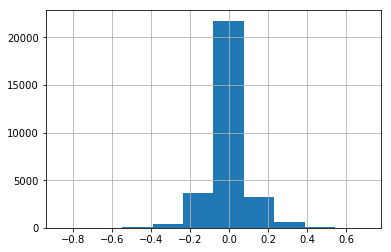

In [67]:
diff.hist()

In [68]:
diff[ diff.abs() > 1 ]

Series([], dtype: float64)

# Get gene expression difference and p-value for desired comparisons

Use Wilcoxon rank-sum statistic for two samples to test if the reads for a given gene across comparison groups come from different distributions.

In [69]:
from scipy.stats import ranksums

In [70]:
import time

In [73]:
all_diffs = {}
all_pvals = {}

for groupa, groupb in [ list(_) for _ in comparisons ]:
    
    t1 = time.time()
    comp_name = groupa + '_vs_' + groupb
    
    # First: select only the columns that are involvoled in this comparison
    groupa_col_names = [ _ for _ in normalized.columns if groupa in _ ]
    groupb_col_names = [ _ for _ in normalized.columns if groupb in _ ]
    groupa_cols = normalized[ groupa_col_names ]
    groupb_cols = normalized[ groupb_col_names ]
    
    # Second: do diffs for all genes in one step:
    all_diffs[ comp_name ] = groupa_cols.mean(axis=1) - groupb_cols.mean(axis=1)
    
    # Third: go row-by-row doing significance test
    pval_list = []
    for groupa_vals, groupb_vals in zip( groupa_cols.as_matrix(), groupb_cols.as_matrix() ):
        statistic, pvalue = ranksums( groupa_vals, groupb_vals ) 
        pval_list.append( pvalue )
    all_pvals[ comp_name ] = pval_list
    
    # Fourth: say how long it took
    t2 = time.time()
    print( "{} completed in {:0.2f} seconds".format( comp_name, t2-t1 ))
    t1 = t2
    
all_diffs = pd.DataFrame.from_dict( all_diffs )
all_pvals = pd.DataFrame.from_dict( all_pvals )
all_diffs.index = all_pvals.index = normalized.index
print( "FINISHED")

BR1_CONTROL_O_vs_BR1_CONTROL_Y completed in 6.24 seconds
BR1_TEST_O_vs_BR1_TEST_Y completed in 6.18 seconds
BR2_CONTROL_O_vs_BR2_CONTROL_Y completed in 6.11 seconds
BR2_TEST_O_vs_BR2_TEST_Y completed in 6.13 seconds
BR1_CONTROL_Y_vs_BR1_TEST_Y completed in 6.16 seconds
BR1_CONTROL_O_vs_BR1_TEST_O completed in 6.10 seconds
BR2_CONTROL_Y_vs_BR2_TEST_Y completed in 6.25 seconds
BR2_CONTROL_O_vs_BR2_TEST_O completed in 6.19 seconds
BR1_CONTROL_O_vs_BR2_CONTROL_O completed in 6.21 seconds
BR1_TEST_O_vs_BR2_TEST_O completed in 6.31 seconds
BR1_CONTROL_Y_vs_BR2_CONTROL_Y completed in 6.23 seconds
BR1_TEST_Y_vs_BR2_TEST_Y completed in 6.19 seconds
FINISHED


In [74]:
all_diffs

,BR1_CONTROL_O_vs_BR1_CONTROL_Y,BR1_CONTROL_O_vs_BR1_TEST_O,BR1_CONTROL_O_vs_BR2_CONTROL_O,BR1_CONTROL_Y_vs_BR1_TEST_Y,BR1_CONTROL_Y_vs_BR2_CONTROL_Y,BR1_TEST_O_vs_BR1_TEST_Y,BR1_TEST_O_vs_BR2_TEST_O,BR1_TEST_Y_vs_BR2_TEST_Y,BR2_CONTROL_O_vs_BR2_CONTROL_Y,BR2_CONTROL_O_vs_BR2_TEST_O,BR2_CONTROL_Y_vs_BR2_TEST_Y,BR2_TEST_O_vs_BR2_TEST_Y
Symbol,,,,,,,,,,,,
A1bg,-0.272510,-0.270540,-0.084454,0.034485,0.116040,0.032515,0.110171,0.122106,-0.072016,-0.075916,0.040550,0.044450
A1cf,-0.026209,-0.031448,0.018202,-0.036207,-0.011803,-0.030967,0.056601,0.042389,-0.056214,0.006951,0.017985,-0.045180
A1i3,-0.050955,0.014744,0.018106,-0.266837,0.014502,-0.332537,-0.070782,0.303619,-0.054559,-0.074144,0.022279,0.041864
A26c2,0.203766,-0.138419,0.006349,0.021364,-0.151383,0.363549,0.122710,-0.172186,0.046033,-0.022059,0.000562,0.068653
A2m,-0.035477,-0.073303,0.528221,0.074346,0.772264,0.112172,0.705756,0.646886,0.208566,0.104232,-0.051032,0.053302
A3galt2,-0.079200,0.013393,0.051706,0.265655,0.250461,0.173063,0.018097,-0.062730,0.119556,-0.020216,-0.047535,0.092236
A4galt,-0.023329,-0.114126,0.013214,-0.131014,0.038682,-0.040216,0.139056,0.162152,0.002139,0.011716,-0.007544,-0.017121
A4gnt,0.051597,0.024227,0.036471,-0.234120,-0.144173,-0.206749,-0.011444,0.104846,-0.129047,-0.023688,0.014899,-0.090459
AA926063,0.009493,-0.177987,-0.308729,-0.254515,-0.271754,-0.067036,-0.123264,0.148732,0.046467,0.007477,0.165971,0.204961


# Number of genes with fold change > 1

In [ ]:
all_diffs.abs()

In [76]:
fold_change = all_diffs.abs() > 1

In [77]:
fold_change.sum()

BR1_CONTROL_O_vs_BR1_CONTROL_Y     0
BR1_CONTROL_O_vs_BR1_TEST_O        0
BR1_CONTROL_O_vs_BR2_CONTROL_O    17
BR1_CONTROL_Y_vs_BR1_TEST_Y        1
BR1_CONTROL_Y_vs_BR2_CONTROL_Y    38
BR1_TEST_O_vs_BR1_TEST_Y           0
BR1_TEST_O_vs_BR2_TEST_O          28
BR1_TEST_Y_vs_BR2_TEST_Y          34
BR2_CONTROL_O_vs_BR2_CONTROL_Y     2
BR2_CONTROL_O_vs_BR2_TEST_O        0
BR2_CONTROL_Y_vs_BR2_TEST_Y        2
BR2_TEST_O_vs_BR2_TEST_Y           0
dtype: int64

# Number of genes with statistically significant different distributions

In [ ]:
(all_pvals < 0.05).sum()

# Both

In [ ]:
((all_diffs.abs() > 1) & (all_pvals < 0.05)).sum()

# Focus on one comparison: BR1_CONTROL_Y_vs_BR2_CONTROL_Y

In [78]:
exp_diffs = all_diffs['BR1_CONTROL_Y_vs_BR2_CONTROL_Y']
exp_pvals = all_pvals['BR1_CONTROL_Y_vs_BR2_CONTROL_Y']

In [79]:
plot_these = exp_diffs.loc[ (exp_diffs.abs() > 1) & (exp_pvals < 0.05) ].sort_values()

In [80]:
plot_these = plot_these.to_frame( name='zscore' )

Turn the row labels into variables in their own right:

In [81]:
plot_these['Gene'] = plot_these.index

# Generate RibbonPlot

## Load some of Python's figure-making libraries:

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

## Tell Python to show the figure after it's done making it:

In [83]:
%matplotlib inline

## Make the figure:

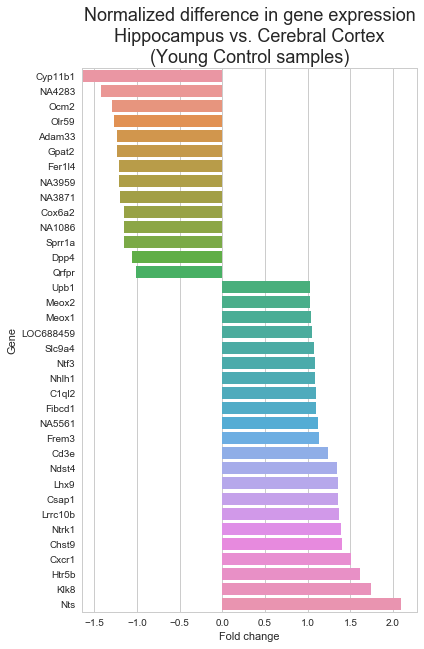

In [85]:
sns.set( style="whitegrid" )
figure, axes = plt.subplots( figsize=(6, 10) )
sns.barplot( data=plot_these, x="zscore", y="Gene" )
chart_title = """Normalized difference in gene expression
Hippocampus vs. Cerebral Cortex
(Young Control samples)"""
axes.set_title( chart_title, size=18 )
axes.set_xlabel( "Fold change")

## Save the figure as a PDF:

In [ ]:
figure.savefig( "ribbonplot.pdf")

# DONE!

# On your own:


In [86]:
Suv420h1 = df[df.Symbol == 'Suv420h1']

In [87]:
Suv420h1.columns

Index(['Symbol', 'AVG_Signal_BR1_TEST_O_1', 'AVG_Signal_BR1_TEST_O_2',
       'AVG_Signal_BR1_TEST_O_3', 'AVG_Signal_BR1_TEST_O_4',
       'AVG_Signal_BR1_TEST_Y_1', 'AVG_Signal_BR1_TEST_Y_2',
       'AVG_Signal_BR1_TEST_Y_3', 'AVG_Signal_BR1_TEST_Y_4',
       'AVG_Signal_BR1_CONTROL_O_1', 'AVG_Signal_BR1_CONTROL_O_2',
       'AVG_Signal_BR1_CONTROL_O_3', 'AVG_Signal_BR1_CONTROL_Y_1',
       'AVG_Signal_BR1_CONTROL_Y_2', 'AVG_Signal_BR1_CONTROL_Y_3',
       'AVG_Signal_BR1_CONTROL_Y_4', 'AVG_Signal_BR2_TEST_O_1',
       'AVG_Signal_BR2_TEST_O_2', 'AVG_Signal_BR2_TEST_O_3',
       'AVG_Signal_BR2_TEST_O_4', 'AVG_Signal_BR2_TEST_Y_1',
       'AVG_Signal_BR2_TEST_Y_2', 'AVG_Signal_BR2_TEST_Y_3',
       'AVG_Signal_BR2_TEST_Y_4', 'AVG_Signal_BR2_CONTROL_O_1',
       'AVG_Signal_BR2_CONTROL_O_2', 'AVG_Signal_BR2_CONTROL_O_3',
       'AVG_Signal_BR2_CONTROL_O_4', 'AVG_Signal_BR2_CONTROL_Y_1',
       'AVG_Signal_BR2_CONTROL_Y_2', 'AVG_Signal_BR2_CONTROL_Y_3',
       'AVG_Signal_BR2_CONTROL_Y_

In [88]:
from scipy.stats.mstats import kruskalwallis

In [89]:
Suv420h1[ Suv420h1.columns[2:]].as_matrix().T

array([[ 2639.498 ,   282.0036,  2632.292 ,  2601.357 ,   328.7193,
          314.7441,   294.0218,  2573.176 ,   317.2552,   331.4735,
          316.1163,   308.6923,  2516.118 ,  2507.476 ,   329.4245,
         2617.768 ,   311.4156,  2480.783 ,  2560.056 ,  2525.45  ],
       [ 2876.917 ,   379.509 ,  3024.015 ,  2937.448 ,   377.0802,
          365.8818,   392.6335,  2826.608 ,   371.7557,   401.4565,
          368.5963,   379.8986,  2878.745 ,  2886.556 ,   387.0985,
         2669.294 ,   375.2104,  2904.073 ,  2886.647 ,  2863.437 ],
       [ 1851.872 ,   241.7938,  1935.529 ,  1825.163 ,   234.9722,
          234.1275,   270.086 ,  1825.918 ,   237.1046,   235.4798,
          258.981 ,   213.4933,  1798.143 ,  1821.942 ,   281.1704,
         1891.023 ,   247.899 ,  1811.208 ,  1875.394 ,  1781.113 ],
       [ 2580.173 ,   260.9355,  2668.782 ,  2622.048 ,   249.9927,
          245.9578,   239.8979,  2498.439 ,   255.8786,   273.6262,
          270.7075,   250.1133,  2540.796 ,  

In [90]:
?kruskalwallis

In [91]:
kruskalwallis( *Suv420h1[ Suv420h1.columns[2:]].as_matrix().T)

KruskalResult(statistic=133.5370249584023, pvalue=2.3290752051055189e-15)

In [ ]:
br2_control_Y_cols = ['AVG_Signal_BR2_CONTROL_Y_1', 'AVG_Signal_BR2_CONTROL_Y_2',
       'AVG_Signal_BR2_CONTROL_Y_3', 'AVG_Signal_BR2_CONTROL_Y_4']

In [ ]:
kruskalwallis( *Suv420h1[ br2_control_Y_cols ].as_matrix().T)

In [ ]:
br2_control_O_cols = ['AVG_Signal_BR2_CONTROL_O_1', 'AVG_Signal_BR2_CONTROL_O_2',
       'AVG_Signal_BR2_CONTROL_O_3', 'AVG_Signal_BR2_CONTROL_O_4']

In [ ]:
kruskalwallis( *Suv420h1[ br2_control_O_cols ].as_matrix().T)

In [ ]:
Suv420h1[ br2_control_O_cols ]